In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/github-bugs-prediction/embold_train.json
/kaggle/input/github-bugs-prediction/embold_test.json
/kaggle/input/github-bugs-prediction/embold_train_extra.json
/kaggle/input/github-bugs-prediction/sample submission.csv


## Importing required library for notebook

In [2]:
#!pip install tensorflow
#!pip install tensorflow_hub
#!pip3 install tensorflow_text

In [3]:
from bs4 import BeautifulSoup
from collections import Counter,defaultdict
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import plotly.graph_objs as go
import plotly.offline as py
from plotly import tools
py.init_notebook_mode(connected=True)
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM, Dense,Flatten,Conv2D,Conv1D,GlobalMaxPooling1D,GlobalMaxPool1D
from keras.optimizers import Adam
import numpy as np  
import pandas as pd 
import keras.backend as k
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional,GRU
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_hub as hub
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
import string
import math
from scipy.spatial.distance import cosine
import transformers
from transformers import BertTokenizer,TFBertModel,AutoTokenizer, pipeline
from unidecode import unidecode
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline
%matplotlib inline

## EDA(Explodatory Data Analysis)

Attribute Description:
1. Title - the title of the GitHub bug <br> 
1. Body - the body of the GitHub bug <br> 
1. Label - Represents various classes of Labels <br> 
 - Bug - 0 <br> 
 - Feature - 1 <br> 
 - Question - 2 <br> 

In [4]:
train_df= pd.read_json("/kaggle/input/github-bugs-prediction/embold_train.json").reset_index(drop=True)
train_df.head()

title  \
0                                  y-zoom piano roll   
1                        buggy behavior in selection   
2                                auto update feature   
3                 filter out noisy endpoints in logs   
4  enable pid on / pid off alarm actions for ardu...   

                                                body  label  
0        a y-zoom on the piano roll would be useful.      1  
1  ! screenshot from 2016-02-23 21 27 40  https:/...      0  
2  hi,\r \r great job so far, @saenzramiro ! : \r...      1  
3  i think we should stop logging requests to:\r ...      1  
4  expected behavior\r alarm actions pid on and p...      0

In [5]:
test_df= pd.read_json("/kaggle/input/github-bugs-prediction/embold_test.json").reset_index(drop=True)
test_df.head()

title  \
0  config question  path-specific environment var...   
1                                   crash indien vol   
2                               unable to mine rocks   
3                   not all whitelists are processed   
4          add ctx menu for idafree 70 and idafree 5   

                                                body  
0  issue description or question\r \r hey @artemg...  
1                de simulator crasht als hij vol zit  
2  sarkasmo starting today, when i hit enter  act...  
3  create following rules... order of creation is...  
4  associated with .dll, .dll_, .exe, .exe_, .sc,...

In [6]:
train_ex_df= pd.read_json("/kaggle/input/github-bugs-prediction/embold_train_extra.json").reset_index(drop=True)
train_ex_df.head()

title  \
0                                use a 8bit typeface   
1                   implement wireless m-bus binding   
2               add multilang support for timeago.js   
3                   scaleway - seg-fault on shutdown   
4  sistema de pintura: no se guardar los nuevos p...   

                                                body  label  
0  since this is meant to emulate some old arcade...      1  
1  _from  chris.pa...@googlemail.com  https://cod...      1  
2  currently it is only  en . \r required to add ...      1  
3  tbr  irc  creates a new scaleway instance with...      0  
4  este sp ya estaba asignado a un carro y se enc...      0

Looks like both the train and train extra dataframe contains the same content so let's combine them using concatenation command of pandas on index axis

Let's check the length of each dataframe

In [7]:
mas_train_df = pd.concat([train_df,train_ex_df],ignore_index=True)
mas_train_df.head()

title  \
0                                  y-zoom piano roll   
1                        buggy behavior in selection   
2                                auto update feature   
3                 filter out noisy endpoints in logs   
4  enable pid on / pid off alarm actions for ardu...   

                                                body  label  
0        a y-zoom on the piano roll would be useful.      1  
1  ! screenshot from 2016-02-23 21 27 40  https:/...      0  
2  hi,\r \r great job so far, @saenzramiro ! : \r...      1  
3  i think we should stop logging requests to:\r ...      1  
4  expected behavior\r alarm actions pid on and p...      0

In [8]:
mas_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450000 entries, 0 to 449999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   title   450000 non-null  object
 1   body    450000 non-null  object
 2   label   450000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 10.3+ MB


Let's drop duplicate if exists no duplicates exists <br>
No duplicates present in training dataset after combining

In [9]:
mas_train_df.drop_duplicates(keep='first').count()

title    450000
body     450000
label    450000
dtype: int64

In [10]:
def fx(x):
    return x['title'] + " " + x['body']   
mas_train_df['text']= mas_train_df.apply(lambda x : fx(x),axis=1)
test_df['text']= test_df.apply(lambda x : fx(x),axis=1)

In [11]:
mas_train_df.head()

title  \
0                                  y-zoom piano roll   
1                        buggy behavior in selection   
2                                auto update feature   
3                 filter out noisy endpoints in logs   
4  enable pid on / pid off alarm actions for ardu...   

                                                body  label  \
0        a y-zoom on the piano roll would be useful.      1   
1  ! screenshot from 2016-02-23 21 27 40  https:/...      0   
2  hi,\r \r great job so far, @saenzramiro ! : \r...      1   
3  i think we should stop logging requests to:\r ...      1   
4  expected behavior\r alarm actions pid on and p...      0   

                                                text  
0  y-zoom piano roll a y-zoom on the piano roll w...  
1  buggy behavior in selection ! screenshot from ...  
2  auto update feature hi,\r \r great job so far,...  
3  filter out noisy endpoints in logs i think we ...  
4  enable pid on / pid off alarm actions for ardu...

## Text Cleaning
let us clean the dataset and remove the redundancies.This includes

1. HTML codes
1. URLs
1. Emojis
1. Stopwords
1. Punctuations
1. Expanding Abbreviations

In [12]:
cList = {
            "i'm": "i am",
            "you're": "you are",
            "it's": "it is",
            "we're": "we are",
            "we'll": "we will",
            "That's":"that is",
            "haven't":"have not",
            "let's":"let us",
            "ain't": "am not / are not / is not / has not / have not",
            "aren't": "are not / am not",
            "can't": "cannot",
            "can't've": "cannot have",
            "'cause": "because",
            "could've": "could have",
            "couldn't": "could not",
            "couldn't've": "could not have",
            "didn't": "did not",
            "doesn't": "does not",
            "don't": "do not",
            "hadn't": "had not",
            "hadn't've": "had not have",
            "hasn't": "has not",
            "haven't": "have not",
            "he'd": "he had / he would",
            "he'd've": "he would have",
            "he'll": "he shall / he will",
            "he'll've": "he shall have / he will have",
            "he's": "he has / he is",
            "how'd": "how did",
            "how'd'y": "how do you",
            "how'll": "how will",
            "how's": "how has / how is / how does",
            "I'd": "I had / I would",
            "I'd've": "I would have",
            "I'll": "I shall / I will",
            "I'll've": "I shall have / I will have",
            "I'm": "I am",
            "I've": "I have",
            "isn't": "is not",
            "it'd": "it had / it would",
            "it'd've": "it would have",
            "it'll": "it shall / it will",
            "it'll've": "it shall have / it will have",
            "it's": "it has / it is",
            "let's": "let us",
            "ma'am": "madam",
            "mayn't": "may not",
            "might've": "might have",
            "mightn't": "might not",
            "mightn't've": "might not have",
            "must've": "must have",
            "mustn't": "must not",
            "mustn't've": "must not have",
            "needn't": "need not",
            "needn't've": "need not have",
            "o'clock": "of the clock",
            "oughtn't": "ought not",
            "oughtn't've": "ought not have",
            "shan't": "shall not",
            "sha'n't": "shall not",
            "shan't've": "shall not have",
            "she'd": "she had / she would",
            "she'd've": "she would have",
            "she'll": "she shall / she will",
            "she'll've": "she shall have / she will have",
            "she's": "she has / she is",
            "should've": "should have",
            "shouldn't": "should not",
            "shouldn't've": "should not have",
            "so've": "so have",
            "so's": "so as / so is",
            "that'd": "that would / that had",
            "that'd've": "that would have",
            "that's": "that has / that is",
            "there'd": "there had / there would",
            "there'd've": "there would have",
            "there's": "there has / there is",
            "they'd": "they had / they would",
            "they'd've": "they would have",
            "they'll": "they shall / they will",
            "they'll've": "they shall have / they will have",
            "they're": "they are",
            "they've": "they have",
            "to've": "to have",
            "wasn't": "was not",
            "we'd": "we had / we would",
            "we'd've": "we would have",
            "we'll": "we will",
            "we'll've": "we will have",
            "we're": "we are",
            "we've": "we have",
            "weren't": "were not",
            "what'll": "what shall / what will",
            "what'll've": "what shall have / what will have",
            "what're": "what are",
            "what's": "what has / what is",
            "what've": "what have",
            "when's": "when has / when is",
            "when've": "when have",
            "where'd": "where did",
            "where's": "where has / where is",
            "where've": "where have",
            "who'll": "who shall / who will",
            "who'll've": "who shall have / who will have",
            "who's": "who has / who is",
            "who've": "who have",
            "why's": "why has / why is",
            "why've": "why have",
            "will've": "will have",
            "won't": "will not",
            "won't've": "will not have",
            "would've": "would have",
            "wouldn't": "would not",
            "wouldn't've": "would not have",
            "y'all": "you all",
            "y'all'd": "you all would",
            "y'all'd've": "you all would have",
            "y'all're": "you all are",
            "y'all've": "you all have",
            "you'd": "you had / you would",
            "you'd've": "you would have",
            "you'll": "you shall / you will",
            "you'll've": "you shall have / you will have",
            "you're": "you are",
            "you've": "you have"
           }

In [13]:
c_re = re.compile('(%s)' % '|'.join(cList.keys()))

In [14]:
def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [15]:
def remove_emoji(string):
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', string) 

In [16]:
def remove_punctuations(data):
    punct_tag=re.compile(r'[^\w\s]')
    data=punct_tag.sub(r'',data)
    return data

In [17]:
def removeSpecialChars(data):
    '''
    Removes special characters which are specifically found in tweets.
    '''
    #Converts HTML tags to the characters they represent
    soup = BeautifulSoup(data, "html.parser")
    data = soup.get_text()

    #Convert www.* or https?://* to empty strings
    data = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',data)

    #Convert @username to empty strings
    data = re.sub('@[^\s]+','',data)
    
    #remove org.apache. like texts
    data =  re.sub('(\w+\.){2,}','',data)

    #Remove additional white spaces
    data = re.sub('[\s]+', ' ', data)
    
    data = re.sub('\.(?!$)', '', data)

    #Replace #word with word
    data = re.sub(r'#([^\s]+)', r'\1', data)

    return data 

In [18]:
def remove_nonenglish_charac(string):
    return re.sub('\W+','', string )

In [19]:
extra_punctuations = ['','.', '``', '...', '\'s', '--', '-', 'n\'t', '_', '–','&']
stopword_list = stopwords.words('english') + list(string.punctuation)+ extra_punctuations + ['u','the','us','say','that','he','me','she','get','rt','it','mt','via','not','and','let','so','say','dont','use','you']

In [20]:
def clean_text(data):
    wordnet_lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer() 
    tokenizer=TweetTokenizer()
    data = unidecode(data)
    data = expandContractions(data)
    tokens = tokenizer.tokenize(data)
    data = ' '.join([tok for tok in tokens if len(tok) > 2 if tok not in stopword_list and not tok.isdigit()])
    data = re.sub('\b\w{,2}\b', '', data)
    data = re.sub(' +', ' ', data)
    data = removeSpecialChars(data)
    data = remove_emoji(data)
    data= [stemmer.stem(w) for w in data.split()]
    return ' '.join([wordnet_lemmatizer.lemmatize(word) for word in data])

In [21]:
mas_train_df['text'].head()

0    y-zoom piano roll a y-zoom on the piano roll w...
1    buggy behavior in selection ! screenshot from ...
2    auto update feature hi,\r \r great job so far,...
3    filter out noisy endpoints in logs i think we ...
4    enable pid on / pid off alarm actions for ardu...
Name: text, dtype: object

In [22]:
mas_train_df['text']=mas_train_df['text'].apply(lambda x: clean_text(x))

In [23]:
mas_train_df['text'].head()

0        y-zoom piano roll y-zoom piano roll would use
1            buggi behavior select screenshot 2016-02-
2    auto updat featur great job far auto updat fea...
3    filter noisi endpoint log think stop log reque...
4    enabl pid pid alarm action arduino tc4 expect ...
Name: text, dtype: object

# Dynamic Embeddings
-  Traditional methods such as Skip-Gram and Continuous Bag-of-Words learn static embeddings by training lookup tables that translate words into dense vectors. Static embeddings are directly useful for solving lexical semantics tasks, and can be used as input representations for downstream problems.
- The contextualized embeddings such as BERT have been shown more effective than static embeddings as NLP input embeddings. Such embeddings are dynamic, calculated according to a sentential context using a network structure.
- Using dynamic embeddings to represent a target word gives us two salient advantages. First, it is useful to resolve ambiguities for polysemous words
- Second, syntax and semantic information over the entire sentence is integrated into the context word representations, which makes them more informative.
- Below Dynamic Word Embeddings have been shown useful for NLP tasks
- ELMo provides deep word representations generated from word-level language modeling using LSTM.
- GPT improves language understanding by generative pre-training based on Transformer.
- BERT investigates a self-attention-network for pre-training deep bidirectional representations. Yang et al. 
- xlnet proposed XLNet, a generalized autoregressive pretraining model that integrating the Transformer-XL
- Let's us try to build each dynamic embeding one by one

# Embeddings from Language Models (ELMo)
- ELMo is a novel way to represent words in vectors or embeddings. These word embeddings are helpful in achieving state-of-the-art (SOTA) results in several NLP tasks <br>
- ELMo word vectors are computed on top of a two-layer bidirectional language model (biLM). This biLM model has two layers stacked together. Each layer has 2 passes — forward pass and backward pass
- The architecture above uses a character-level convolutional neural network (CNN) to represent words of a text string into raw word vectors
- These raw word vectors act as inputs to the first layer of biLM
- The forward pass contains information about a certain word and the context (other words) before that word
- The backward pass contains information about the word and the context after it
- This pair of information, from the forward and backward pass, forms the intermediate word vectors
  These intermediate word vectors are fed into the next layer of biLM
- The final representation (ELMo) is the weighted sum of the raw word vectors and the 2 intermediate word vectors
- As the input to the biLM is computed from characters rather than words, it captures the inner structure of the word
- ELMo word representations take the entire input sentence into equation for calculating the word embeddings

- TensorFlow Hub is a library that enables transfer learning by allowing the use of many machine learning models for different tasks. ELMo is one such example.

In [24]:
# Convert the textual reviews to list for analysing sentences(sentence vectors)
text_lst = mas_train_df['text'].tolist()

In [25]:
elmo = hub.load("https://tfhub.dev/google/elmo/2")

In [26]:
def create_elmo_embeddings(data):
    embed=elmo(data,signature="default",as_dict=True)["elmo"]
    print(embed.shape)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
        out_x=sess.run(embed)
        # return average of ELMo features
        return out_x

In [27]:
#elmo_input = text_lst[:2]
#elmo_output = create_elmo_embeddings(elmo_input)

# Transformers
- We come to Transformer Embeddings for which the most important aspect is the Transformer architecture. Since we will be diving in depth into architectures in the Machine LEarning Training session (model building), it is safe to have a glimpse of a traditional Transformer Architecture.
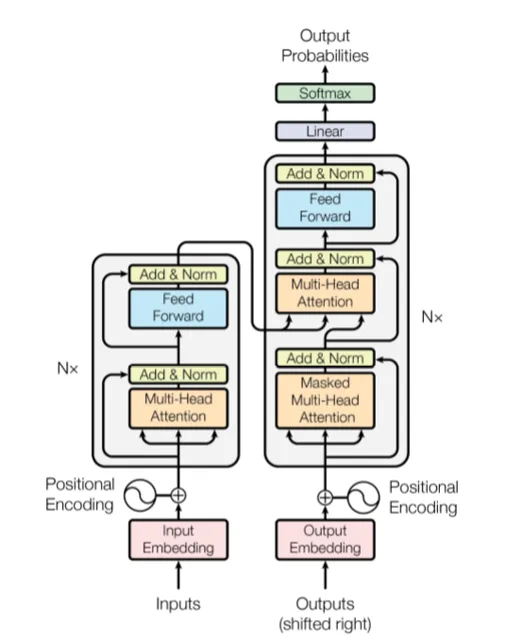
- We will be working with the HuggingFace repository as it contains all SOTA Transformer models. In this context
- While BERT, the first Transformer, relies on 2 tokens ([CLS] and [SEP]) ,extracting the sentence embedding vectors are done after extracting the last output layer. However , different models have different number of layers, and in this case, we will exploring a model agnostic way to extract sentence embeddings and performing similarity check with all of the models.

# BERT Embedding (Bidirectional Encoder Representations from Transformer)

- The importance of using BERT is that it has 2 important aspects:

* Msked Language Model (MLM)
* Next Sentence Prediction(NSP)
- They employed masked language modeling. In other words, they hid 15% of the words and used their position information to infer them. Finally, they also mixed it up a little bit to make the learning process more effective.
- In fact, BERT developers created two main models:
* The BASE: Number of transformer blocks (L): 12, Hidden layer size (H): 768 and Attention heads(A): 12
* The LARGE: Number of transformer blocks (L): 24, Hidden layer size (H): 1024 and Attention heads(A): 16
to make things clearer it is important to understand the special tokens that BERT authors used for fine-tuning and specific task training. These are the following:
1. [CLS] : The first token of every sequence. A classification token which is normally used in conjunction with a softmax layer for classification tasks. For anything else, it can be safely ignored
1. [SEP] : A sequence delimiter token which was used at pre-training for sequence-pair tasks (i.e. Next sentence prediction). Must be used when sequence pair tasks are required. When a single sequence is used it is just appended at the end.
1. [MASK] : Token used for masked words. Only used for pre-training

In [28]:
bert_tokenizer =  BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)
bert_model = TFBertModel.from_pretrained('bert-large-uncased')

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [29]:
def bert_encode(data,max_len):
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = bert_tokenizer.encode_plus(
        
          data[i],
          add_special_tokens = True,
          max_length = max_len,
          pad_to_max_length = True,        
          return_attention_mask = True,        
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)
        

In [30]:
train_input_ids,train_attention_masks = bert_encode(mas_train_df['text'][:5],1000)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


* The size of the simple NN model built with BERT as intermediate Embedding Layer can be observed. Bert-large-uncased has 24-layer, 1024-hidden, 16-heads, 336M parameters and trained on lower-cased English text.

In [31]:
input_ids = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
input_masks_ids = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32')
bert_output=bert_model([input_ids,input_masks_ids])[0]
bert_output.shape
bert_output[:,0,:]
model=Model(inputs=[input_ids,input_masks_ids],outputs=[bert_output])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 128, 1024),  335141888   input_token[0][0]                
                                                                 masked_token[0][0]               
Total params: 335,141,888
Trainable params: 335,141,888
Non-trainable params: 0
__________________________________________________________________________________________________


# Using the Transfomer Method
In this case , we will be using the HuggingFace Transformer method for extracting sentence embeddings. This is a rather simpler method as we only need to extract the last layer from from the model output. The model in this case is bert-base-uncased (12-layer, 768-hidden, 12-heads, 110M parameters.Trained on lower-cased English text.).This code segment is model agnostic and can be used for any variats of BERT (except T5, GPT variants)

In [32]:
def Get_Transformer_Embedding(transformer_model,tokenizer,name,inp):
    tokenizr = tokenizer.from_pretrained(name)
    model = transformer_model.from_pretrained(name)
    input_ids = tf.constant(tokenizr.encode(inp))[None,:]
    outputs = model(input_ids)
    lst_hidd_state = outputs[0]
    return lst_hidd_state[0]    

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


tf.Tensor(
[[-0.62623376 -0.23055266  0.40383556 ... -0.6561966   0.23424959
   0.7053195 ]
 [ 0.79800016 -0.21555875  0.51957244 ... -0.02141146  0.44514441
   0.17238955]
 [-0.4229155   0.32130283  1.0185775  ... -0.30840528 -0.10398383
  -0.08970173]
 ...
 [-0.9261444  -0.319524   -0.05152724 ... -1.0106893   0.3901071
  -0.18003148]
 [-0.30988726 -0.07256829  0.3521775  ... -0.40196982 -0.0085067
   0.21405883]
 [ 0.8146466   0.18994288  0.1364519  ...  0.07886161 -0.50084716
  -0.45819962]], shape=(14, 768), dtype=float32)
(14, 768)


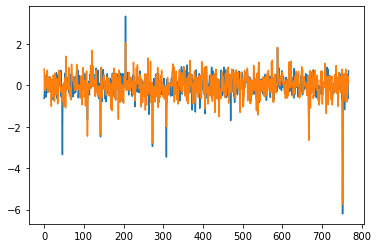

In [33]:
cls_token = Get_Transformer_Embedding(TFBertModel,BertTokenizer,'bert-base-uncased',text_lst[0])
print(cls_token)
print(cls_token.shape)
plt.plot(cls_token[0])
plt.plot(cls_token[1])
plt.show()

# Embedding using pipeline
- This is a robust and efficient way to generate sentence vectors and compute corrspoinding distances between those vectors. It is a faster way which applies to almost all transformers

In [34]:
def build_transformer_embedding(name,inp,model_name,IsGpt = False):

    model = model_name.from_pretrained(name)
    tokenizer = AutoTokenizer.from_pretrained(name)
    if IsGpt:
        tokenizer.pad_token = "[PAD]"        
    pipe = pipeline('feature-extraction', model=model,tokenizer=tokenizer)
    features = pipe(inp)
    features = np.squeeze(features)
    return features

In [35]:
def Generate_Embedding(name,model_name,IsGpt = False):
    embedding_features1 = build_transformer_embedding(name,text_lst[0],model_name,IsGpt)
    embedding_features2 = build_transformer_embedding(name,text_lst[1],model_name,IsGpt)
    distance= 1- cosine(embedding_features1[0],embedding_features2[0])
    print(distance)
    plt.plot(embedding_features1[0])
    plt.plot(embedding_features2[0])

# BERT Embeddings

# DistilBERT
- It's a distilled version of pretraining BERT to produce a lightweight version of it. It is analogous to teacher supervision of a neural network learning to optimize tis weights. DistilBERT Paper provides an insight why it is 40% smaller but preserves 95% of BERT's weights for transfer learning.

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
Some layers from the model checkpoint at distilbert-base-uncased were no

0.8762459758561766


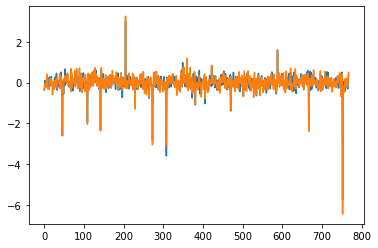

In [36]:
from transformers import TFDistilBertModel
Generate_Embedding('distilbert-base-uncased',TFDistilBertModel)

# Roberta Model Embedding
- It is a robust and large model built by Facebook Research, to alleviate undertrained nature of BERT. It trains in much larger mini-batch sizes. This provides a good model of how to train Roberta on Google cloud.The original paper can be found here, and the model architecture is provided.

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


0.9982516586423134


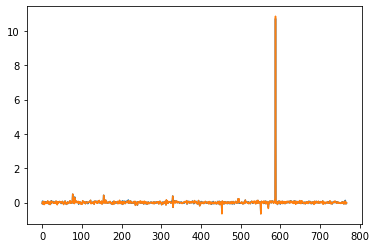

In [37]:
from transformers import TFRobertaModel
Generate_Embedding('roberta-base',TFRobertaModel)

## XLNet Embeddings
- It provides an important outline of the modifications made on top of BERT for producing XLNet. It applies an autoregressive language model and has the 2 most important points:

- Enables learning bidirectional contexts by maximizing the expected likelihood over all permutations of the factorization order
- Overcomes the limitations of BERT thanks to its autoregressive formulation.
- It is a permutation language model and a pictorial representation can be :

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


0.9410768269607004


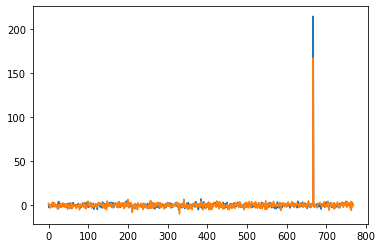

In [38]:
from transformers import TFXLNetModel
Generate_Embedding('xlnet-base-cased',TFXLNetModel)

# BART Model
- It is alternate SOTA model to denoise sentence2 sentence pretraining for natural language generation,comprehension etc. The most important points can be summarized as:

- Bart uses a standard seq2seq/machine translation architecture with a bidirectional encoder (like BERT) and a left-to-right decoder (like GPT).

- The pretraining task involves randomly shuffling the order of the original sentences and a novel in-filling scheme, where spans of text are replaced with a single mask token.

- BART is particularly effective when fine tuned for text generation but also works well for comprehension tasks. It matches the performance of RoBERTa with comparable training resources on GLUE and SQuAD, achieves new state-of-the-art results on a range of abstractive dialogue, question answering, and summarization tasks, with gains of up to 6 ROUGE.

- The architecture contains these encoder -decoder modules :
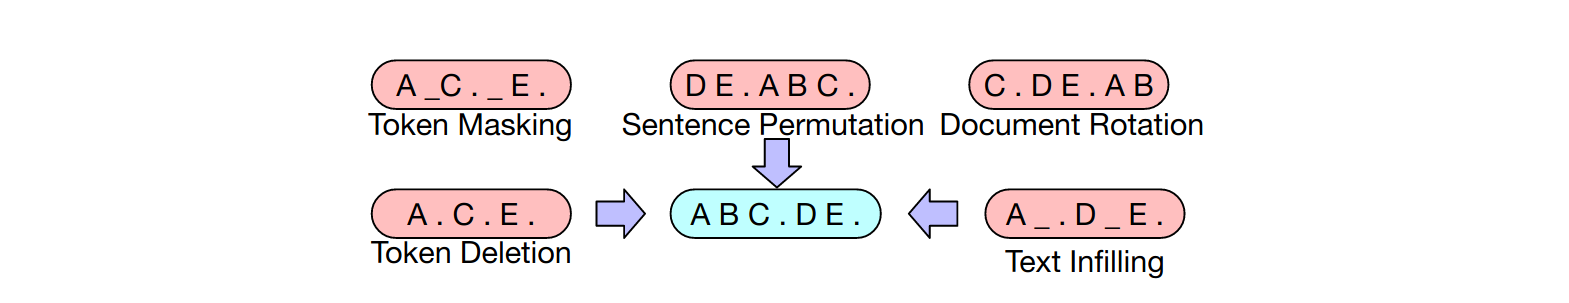


0.9869388586660446


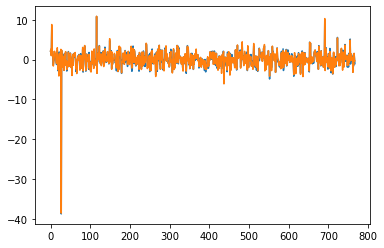

In [39]:
from transformers import BartModel
Generate_Embedding('facebook/bart-base',BartModel)

# Albert Model
- It is a lighter version of BERT which splits the embedding matrix into 2 smaller matrices and uses repeated splitting in between the transformer layers.Some important points:

- ALBERT is a model with absolute position embeddings so it’s usually advised to pad the inputs on the right rather than the left.

- ALBERT uses repeating layers which results in a small memory footprint, however the computational cost remains similar to a BERT-like architecture with the same number of hidden layers as it has to iterate through the same number of (repeating) layers.

Some layers from the model checkpoint at albert-base-v1 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at albert-base-v1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Some layers from the model checkpoint at albert-base-v1 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at albert-base-v1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


0.6746184114105684


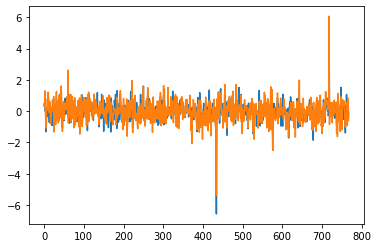

In [40]:
from transformers import TFAlbertModel
Generate_Embedding('albert-base-v1',TFAlbertModel)

# sophisticated variants of BERT


0.7214744168791882


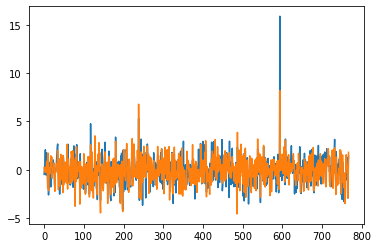

In [41]:
from transformers import FlaubertModel
Generate_Embedding('flaubert/flaubert_base_cased',FlaubertModel)

# GPT (Generative Pretraining)
- This is a different model from BERT and its variants built primarily for NLG (generative modelling). GPT has the following important points:

- GPT is a model with absolute position embeddings so it’s usually advised to pad the inputs on the right rather than the left.

- GPT was trained with a causal language modeling (CLM) objective and is therefore powerful at predicting the next token in a sequence. Leveraging this feature allows GPT-2 to generate syntactically coherent text as it can be observed in the run_generation.py example script
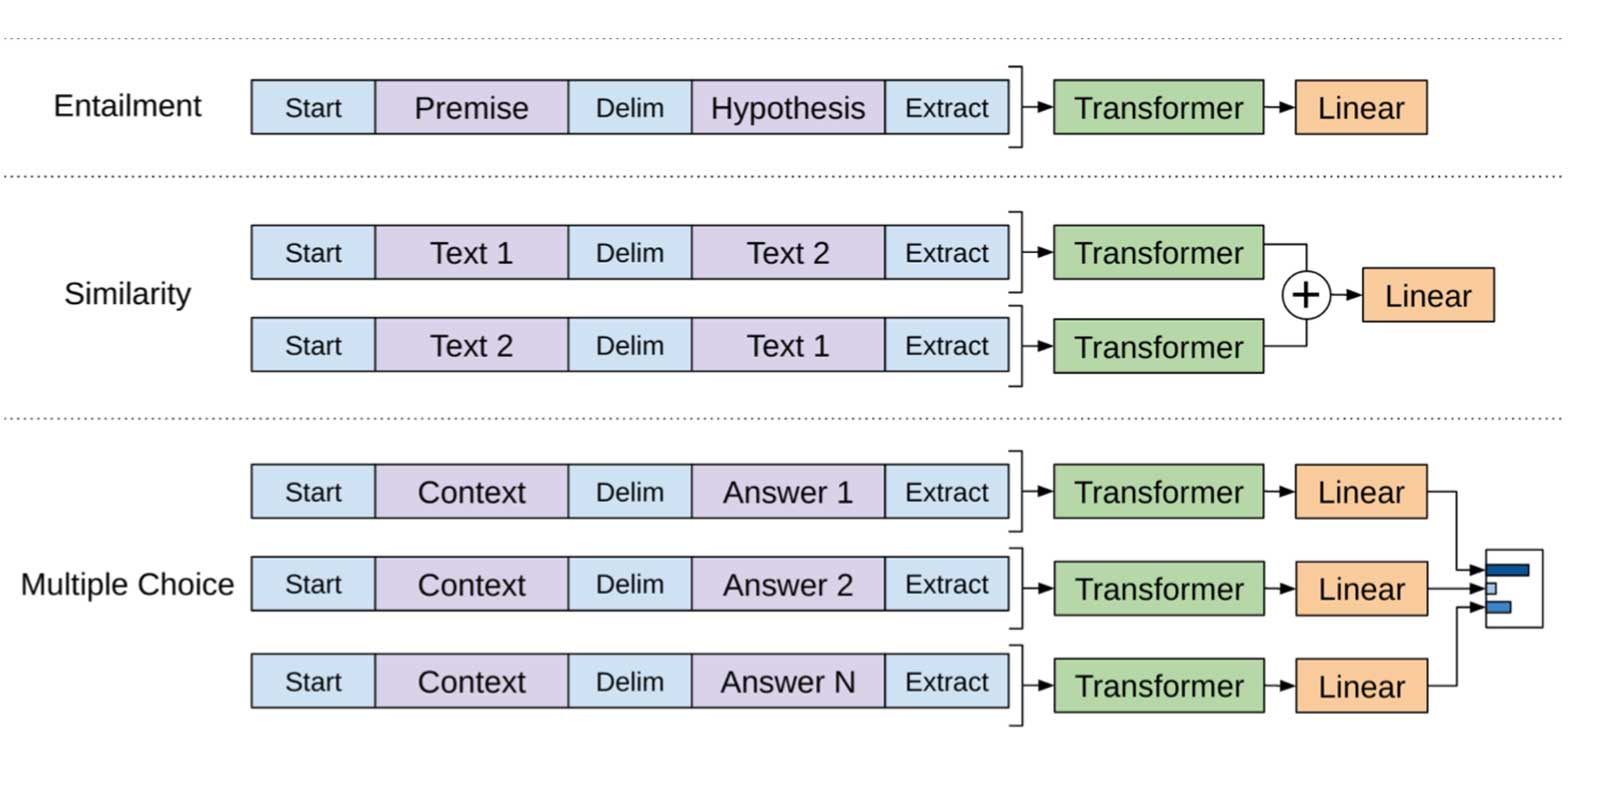

All model checkpoint layers were used when initializing TFOpenAIGPTModel.

All the layers of TFOpenAIGPTModel were initialized from the model checkpoint at openai-gpt.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFOpenAIGPTModel for predictions without further training.


ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


All model checkpoint layers were used when initializing TFOpenAIGPTModel.

All the layers of TFOpenAIGPTModel were initialized from the model checkpoint at openai-gpt.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFOpenAIGPTModel for predictions without further training.
ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


0.2996652617211891


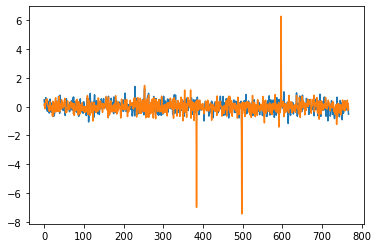

In [42]:
from transformers import TFOpenAIGPTModel
Generate_Embedding('openai-gpt',TFOpenAIGPTModel,True)

# GPT-2
- It is a robust model. GPT-2 is a large transformer-based language model with 1.5 billion parameters, trained on a dataset[1] of 8 million web pages. GPT-2 is trained with a simple objective: predict the next word, given all of the previous words within some text. The diversity of the dataset causes this simple goal to contain naturally occurring demonstrations of many tasks across diverse domains. GPT-2 is a direct scale-up of GPT, with more than 10X the parameters and trained on more than 10X the amount of data.Some important aspects:

- GPT-2 is a model with absolute position embeddings so it’s usually advised to pad the inputs on the right rather than the left.

- GPT-2 was trained with a causal language modeling (CLM) objective and is therefore powerful at predicting the next token in a sequence. Leveraging this feature allows GPT-2 to generate syntactically coherent text as it can be observed in the run_generation.py example scrip
- It is important to note the effect of Attention and masking in GPT-2 model. These are represented in the diagram:

Some layers from the model checkpoint at openai-gpt were not used when initializing TFGPT2Model: ['tokens_embed/weight:0', 'positions_embed/embeddings:0']
- This IS expected if you are initializing TFGPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFGPT2Model were not initialized from the model checkpoint at openai-gpt and are newly initialized: ['wpe/embeddings:0', 'ln_f/beta:0', 'ln_f/gamma:0', 'wte/weight:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.
Some layers 

0.9903447139704202


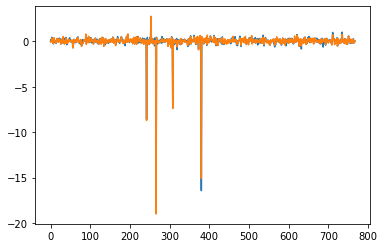

In [43]:
from transformers import TFGPT2Model
Generate_Embedding('openai-gpt',TFGPT2Model,True)

Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraModel: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFElectraModel were initialized from the model checkpoint at google/electra-small-discriminator.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further training.


Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraModel: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFElectraModel were initialized from the model checkpoint at google/electra-small-discriminator.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further training.


0.6945906425464324


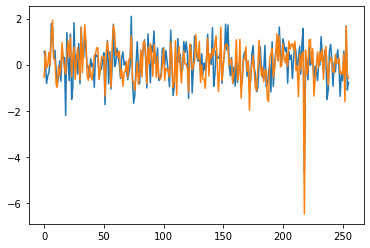

In [44]:
from transformers import TFElectraModel
Generate_Embedding('google/electra-small-discriminator',TFElectraModel)

Some layers from the model checkpoint at allenai/longformer-base-4096 were not used when initializing TFLongformerModel: ['lm_head']
- This IS expected if you are initializing TFLongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFLongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFLongformerModel were initialized from the model checkpoint at allenai/longformer-base-4096.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFLongformerModel for predictions without further training.
Some layers from the model checkpoint at allenai/longformer-base-4096 were not used when initializing TFLongformerModel: ['lm_

0.9974310129886863


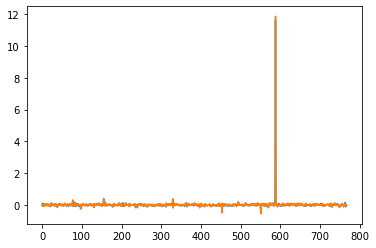

In [45]:
from transformers import TFLongformerModel
Generate_Embedding('allenai/longformer-base-4096',TFLongformerModel)